# Main Training Script

In [1]:
import os
import sys
from pathlib import Path
# Get the current notebook's directory
notebook_dir = Path().resolve()
# Go up one directory level (parent of the current directory)
parent_dir = notebook_dir.parent
# Insert the parent directory into sys.path
sys.path.insert(0, str(parent_dir))
import torch
from datasets.datasets import MetaAudioDataset
from models.main_modules import EncoderModule, SelfAttention, ProjectionHead
from models.prototypical import ContrastivePrototypicalNetworks,ContrastivePrototypicalNetworksWithoutAttention
from loops.loops import contrastive_training_loop, evaluate_multisegment_loop,evaluate_single_segment
from torch.optim.lr_scheduler import MultiStepLR
from loops.loss import FSL_Loss, CPL_Loss
import json
import warnings
import torchaudio
from tqdm import tqdm
warnings.filterwarnings("ignore")

import os
import sys
from pathlib import Path
# Get the current notebook's directory
notebook_dir = Path().resolve()
# Go up one directory level (parent of the current directory)
parent_dir = notebook_dir.parent
# Insert the parent directory into sys.path
sys.path.insert(0, str(parent_dir))
## Read config files
experiment_config = "../experiment_config.json"
model_config = "../models/model_params.json"
with open(experiment_config, "r") as f:
    experiment_config = json.load(f)

with open(model_config, "r") as f:
    model_config = json.load(f)

## Choosing the dataset
data_root = '/data'
dataset_name = experiment_config['dataset_name']
dataset_path = data_root + "/" + dataset_name

## Choose device
device_name = experiment_config['device']
gpu_index = experiment_config['gpu_index']
if device_name == 'cpu':
    device = device_name
elif device_name == 'cuda':
    device = device_name + f":{gpu_index}"

## Choose training specifics
n_way = experiment_config['n_way']
n_shot = experiment_config['n_shot']
n_query = experiment_config['n_query']
tie_strategy = experiment_config['tie_strategy']
multi_segm = experiment_config['multi_segm']
epochs = experiment_config['num_epochs']
n_training_tasks = experiment_config['n_training_tasks']
n_testing_tasks = experiment_config['n_testing_tasks']
lr = experiment_config['lr']
l_param = experiment_config['l_param']
m_param = experiment_config['m_param']
t_param = experiment_config['t_param']

print(f"Loading Dataset:::  {dataset_name}, Device used:::  {device}")

train_set = MetaAudioDataset(experiment_config = experiment_config,root=dataset_path, split='train')
val_set = MetaAudioDataset(experiment_config = experiment_config, root=dataset_path, split='valid')
test_set = MetaAudioDataset(experiment_config, root=dataset_path, split='test')

## Initialize Model, loss ,etc
encoder_str = experiment_config['encoder_name']
patience = experiment_config['patience']
scheduler_milestones = experiment_config['scheduler_milestones']
scheduler_gamma = experiment_config['scheduler_gamma']
experiment_folder = experiment_config['experiment_folder']

## Create the experiment folder in experiments
experiment_results_folder = f"experiments/{experiment_folder}"
try:
    os.mkdir(f"experiments/{experiment_folder}")
except:
    Exception("Already exists")

backbone = EncoderModule(experiment_config=experiment_config, model_config=model_config)
attention = SelfAttention(model_config=model_config)
projection = ProjectionHead(model_config=model_config)
if experiment_config['skip_attention'] == True:
    few_shot_model = ContrastivePrototypicalNetworksWithoutAttention(backbone = backbone, projection_head = projection).to(device)
else:
    few_shot_model = ContrastivePrototypicalNetworks(backbone=backbone,
                                                    attention_model=attention,
                                                    projection_head=projection).to(device)

fsl_loss = FSL_Loss().to(device)
cpl_loss = CPL_Loss(T=t_param, M=m_param).to(device)
train_optimizer = torch.optim.Adam(few_shot_model.parameters(), lr=lr)
## Initialize scheduler
train_scheduler = MultiStepLR(train_optimizer, milestones=scheduler_milestones, gamma=scheduler_gamma)
print("Starting to train")
project_prototypes = experiment_config['project_prototypes']
normalize_prototypes = experiment_config['normalize_prototypes']
feat_extractor  =  torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=128,
    n_fft=1024,
    hop_length=512,
    power=2.0,
).to(device)


    

Loading Dataset:::  ESC-50-master, Device used:::  cuda:1
Num Layers: 1 -> Trainable Params: 124544
Starting to train


In [ ]:
trained_model = contrastive_training_loop(model=few_shot_model,
                                              train_dataset = train_set, 
                                              validation_dataset = val_set, 
                                              optimizer = train_optimizer, 
                                              num_train_tasks = n_training_tasks, 
                                              num_val_tasks = n_training_tasks, 
                                              device = device, 
                                              fsl_loss_fn = fsl_loss, 
                                              cpl_loss_fn = cpl_loss, 
                                              l_param = l_param, 
                                              epochs = epochs, 
                                              train_scheduler = train_scheduler, 
                                              patience = patience, 
                                              results_path = experiment_folder, 
                                              project_prototypes = project_prototypes, 
                                              normalize_prototypes = normalize_prototypes, 
                                              n_classes = n_way, 
                                              k_support = n_shot, 
                                              k_query = n_query, feat_extractor= feat_extractor)
print(trained_model)
print("Starting to test")
if multi_segm == False:
    msg = evaluate_single_segment(model = trained_model, 
                                    dataset = test_set, 
                                    num_val_tasks = n_testing_tasks, 
                                    device = device, 
                                    n_classes = n_way, 
                                    k_support =  n_shot, 
                                    k_query = n_query, feat_extractor=feat_extractor)

else:
    msg = evaluate_multisegment_loop(test_dataset = test_set, 
                                        n_classes = n_way, 
                                        k_support = n_shot, 
                                        k_query = n_query, 
                                        num_test_tasks = n_testing_tasks, 
                                        trained_model = trained_model, 
                                        device = device, 
                                        tie_strategy = tie_strategy, feat_extractor= feat_extractor)

                            
print(msg)


  0%|          | 0/20 [00:00<?, ?it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
1
4
5
6
7


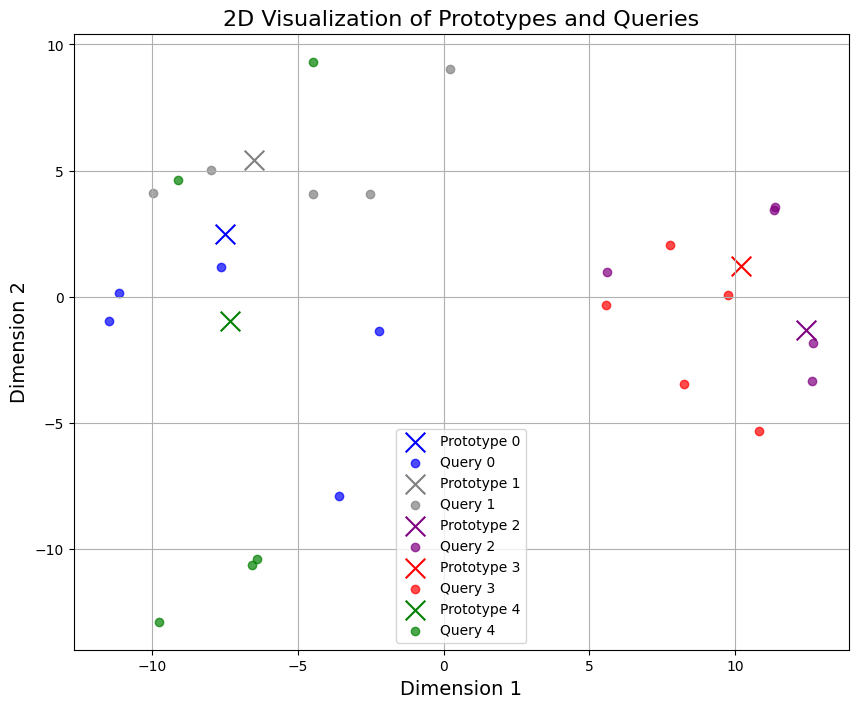

  5%|▌         | 1/20 [00:00<00:05,  3.20it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
1
2
5
8
9


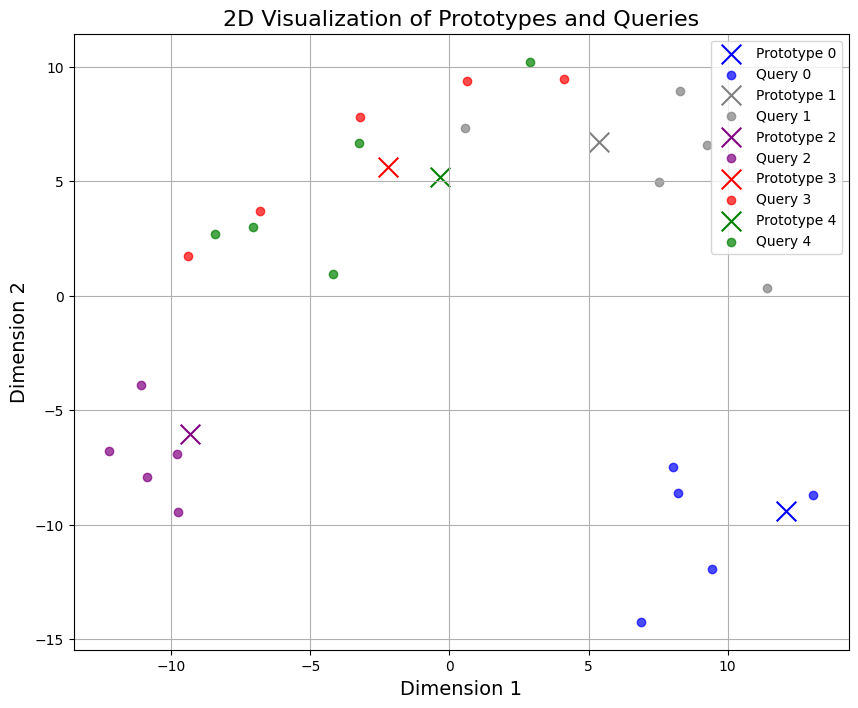

 10%|█         | 2/20 [00:00<00:03,  4.57it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
1
2
3
4
6


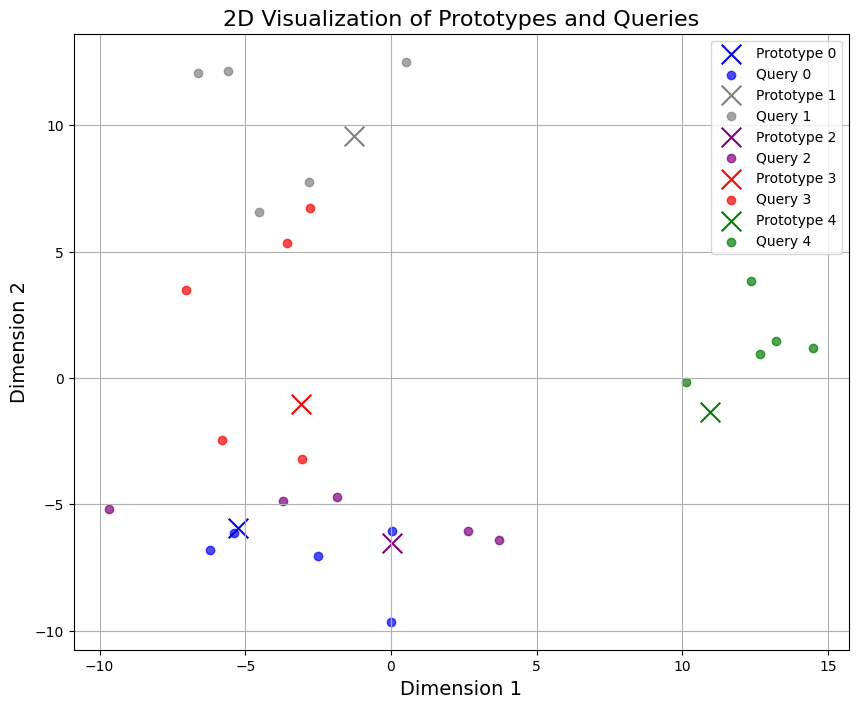

 15%|█▌        | 3/20 [00:00<00:03,  5.45it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
0
1
2
4
5


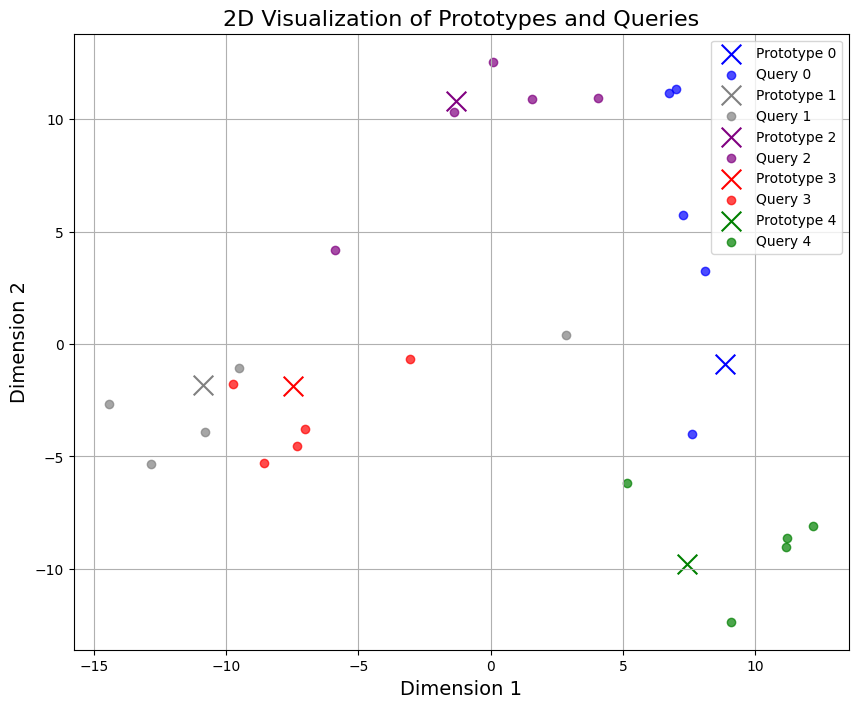

 20%|██        | 4/20 [00:00<00:02,  5.88it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
0
4
5
6
9


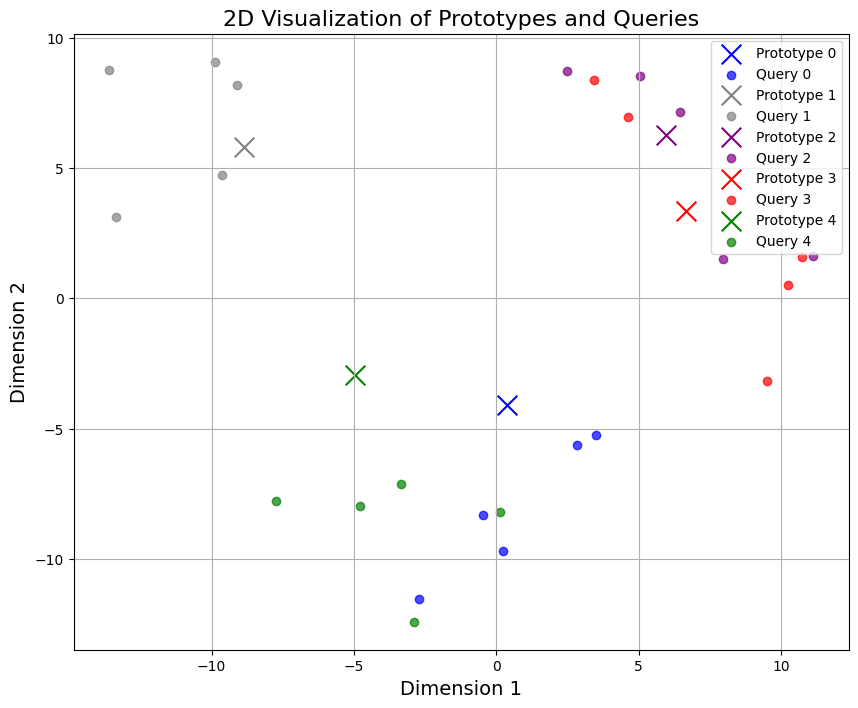

 25%|██▌       | 5/20 [00:00<00:02,  6.33it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
3
4
6
8
9


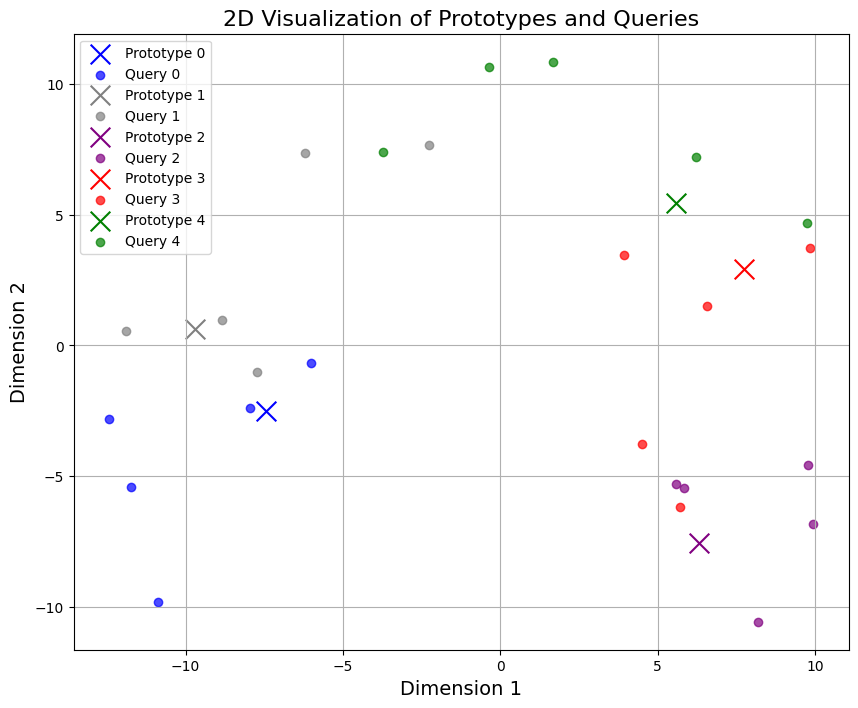

 30%|███       | 6/20 [00:01<00:02,  4.94it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
1
4
5
6
8


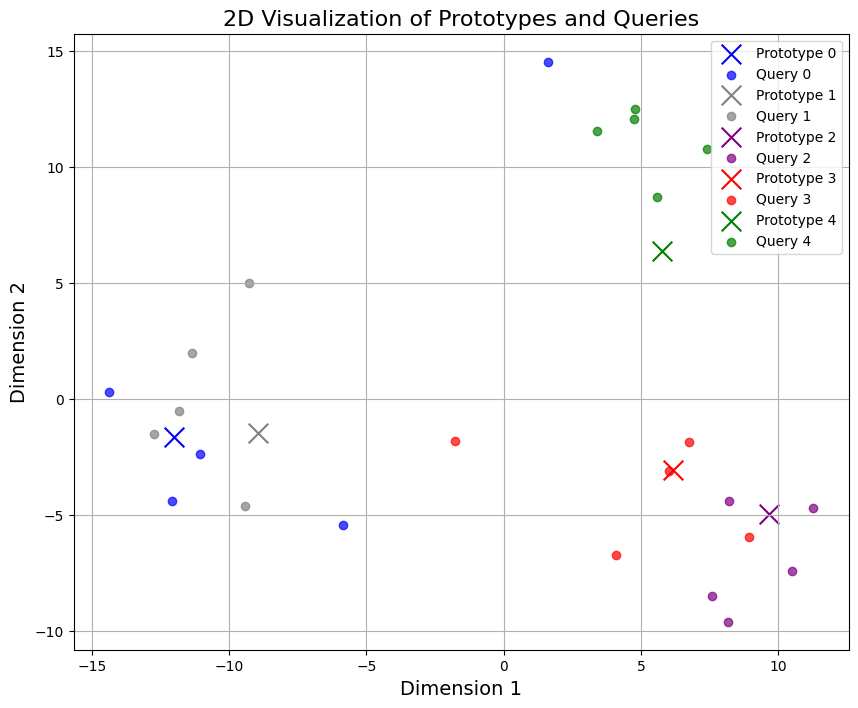

 35%|███▌      | 7/20 [00:01<00:02,  5.44it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
0
2
3
5
9


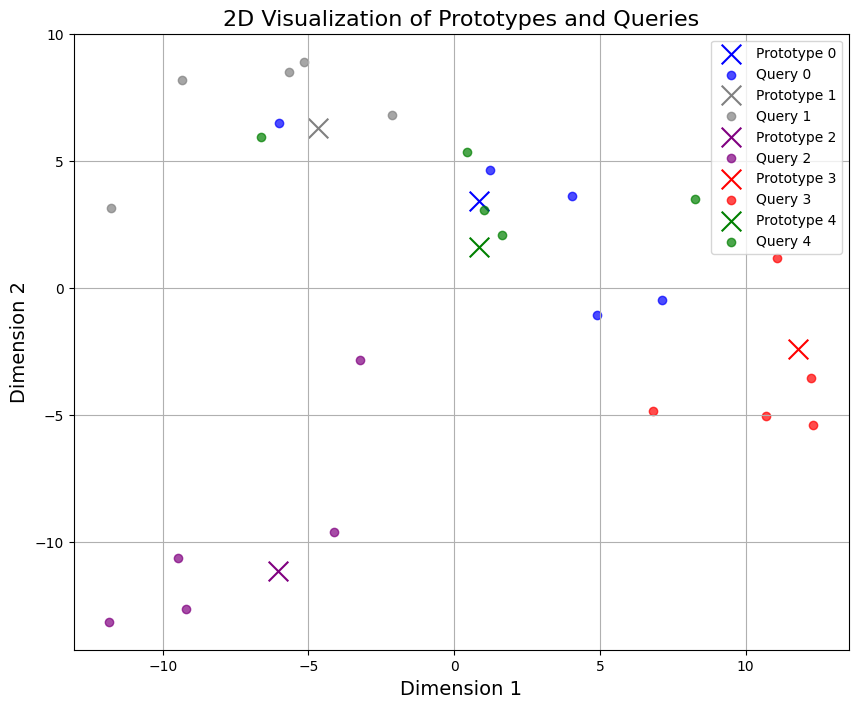

 40%|████      | 8/20 [00:01<00:02,  5.93it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
2
5
6
8
9


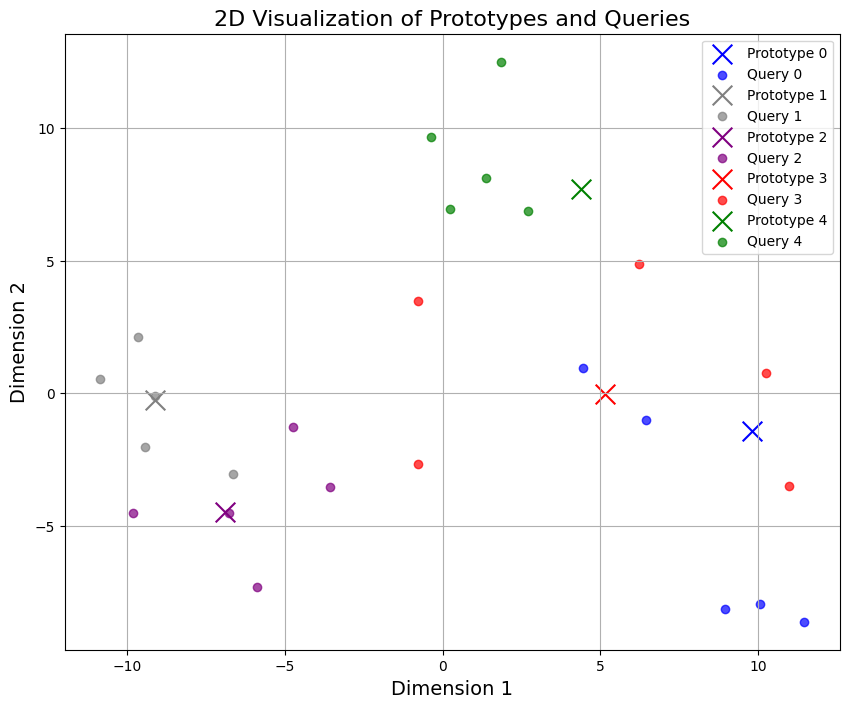

 45%|████▌     | 9/20 [00:01<00:01,  6.34it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
0
1
3
8
9


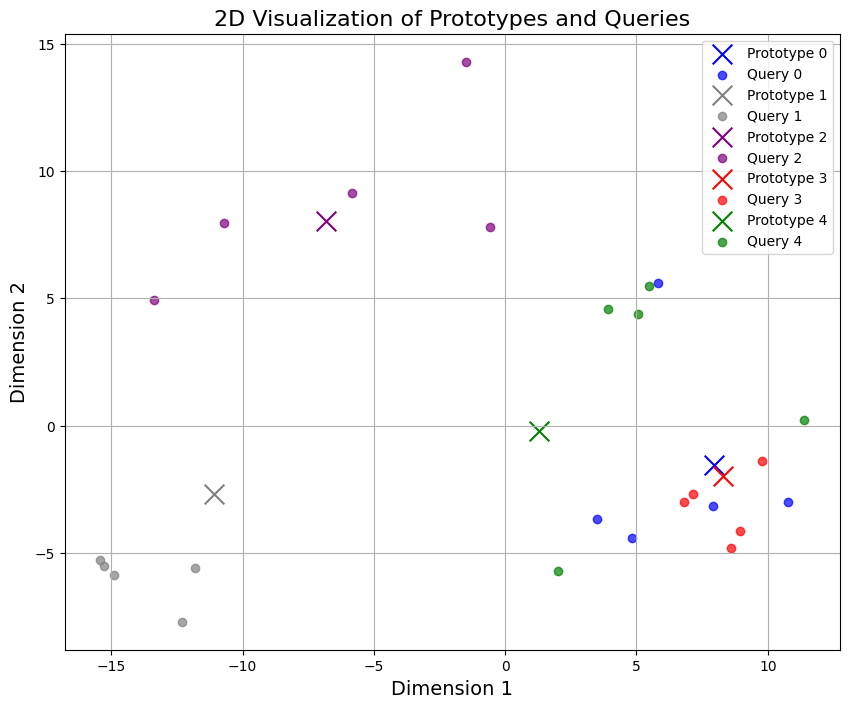

 50%|█████     | 10/20 [00:01<00:01,  5.73it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
0
3
5
8
9


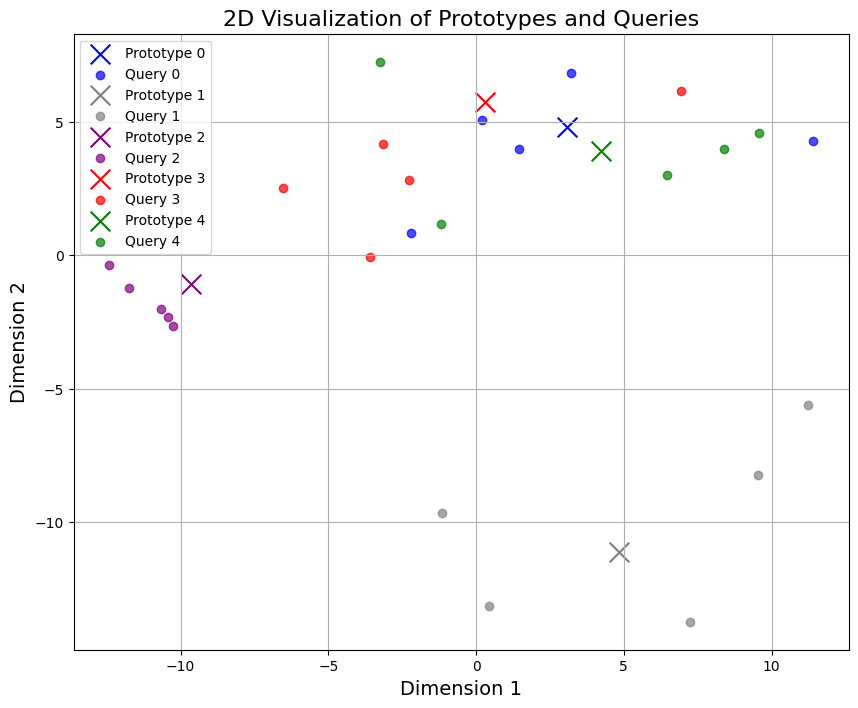

 55%|█████▌    | 11/20 [00:01<00:01,  6.03it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
2
4
6
7
8


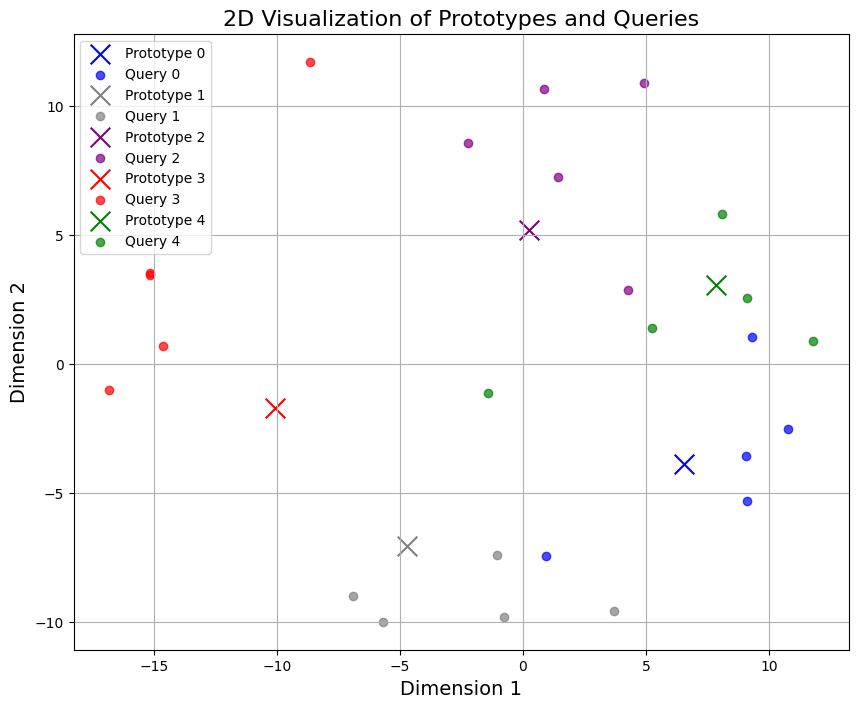

 60%|██████    | 12/20 [00:02<00:01,  5.97it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
2
5
6
8
9


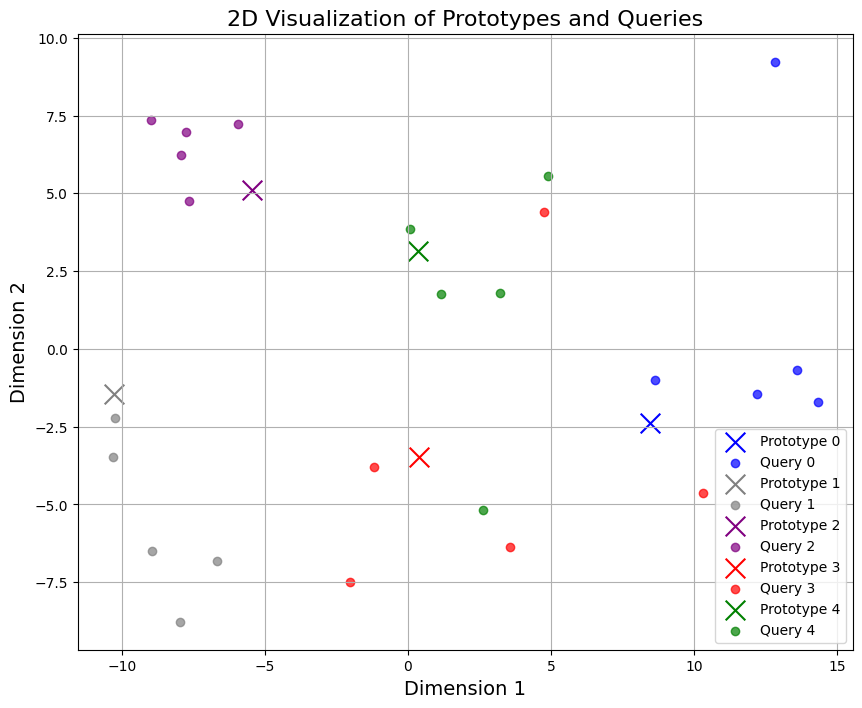

 65%|██████▌   | 13/20 [00:02<00:01,  6.12it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
2
4
5
8
9


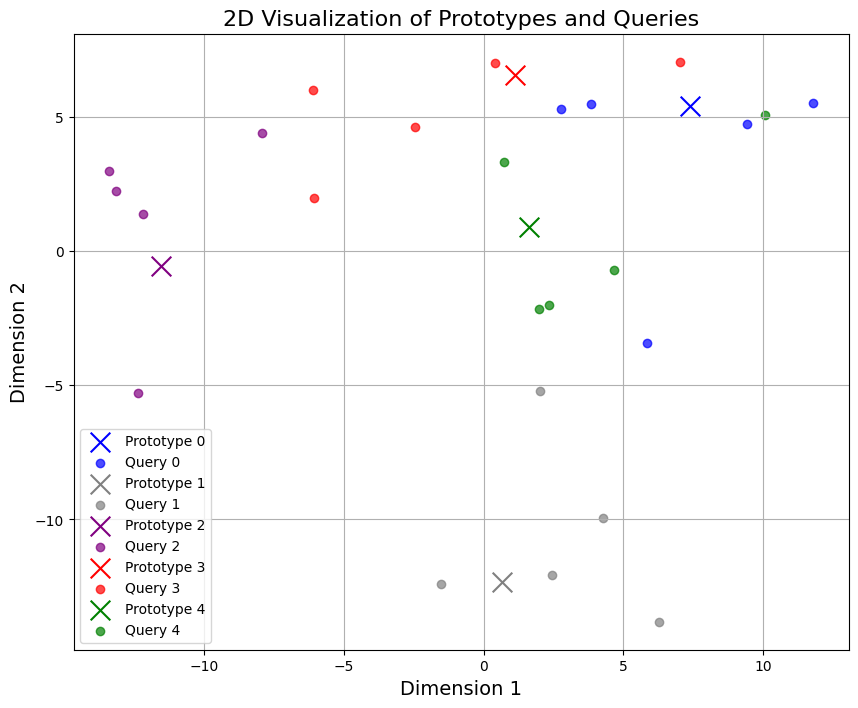

 70%|███████   | 14/20 [00:02<00:00,  6.15it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
1
2
3
4
8


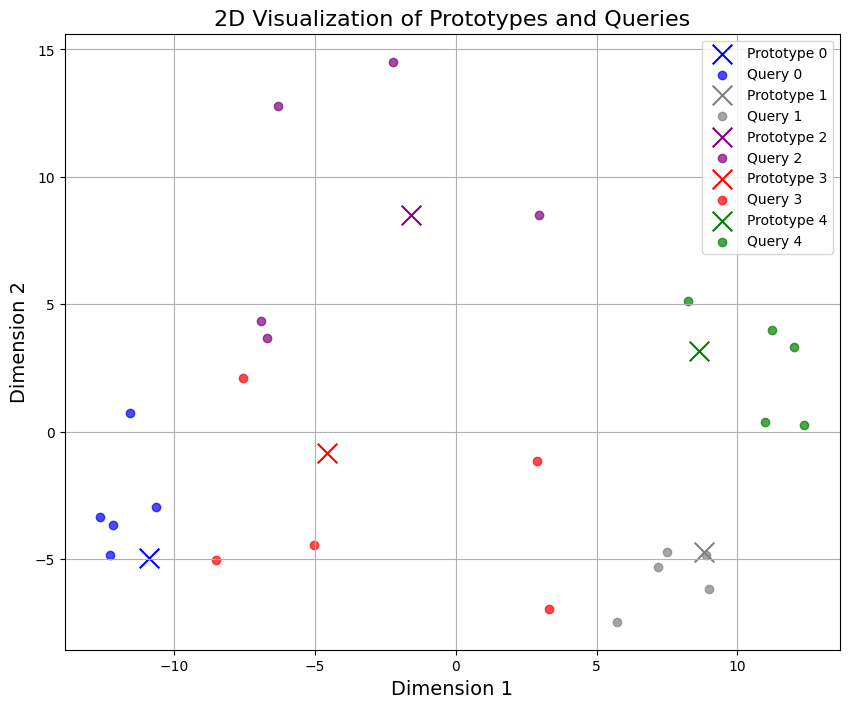

 75%|███████▌  | 15/20 [00:02<00:00,  5.25it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
0
5
6
7
8


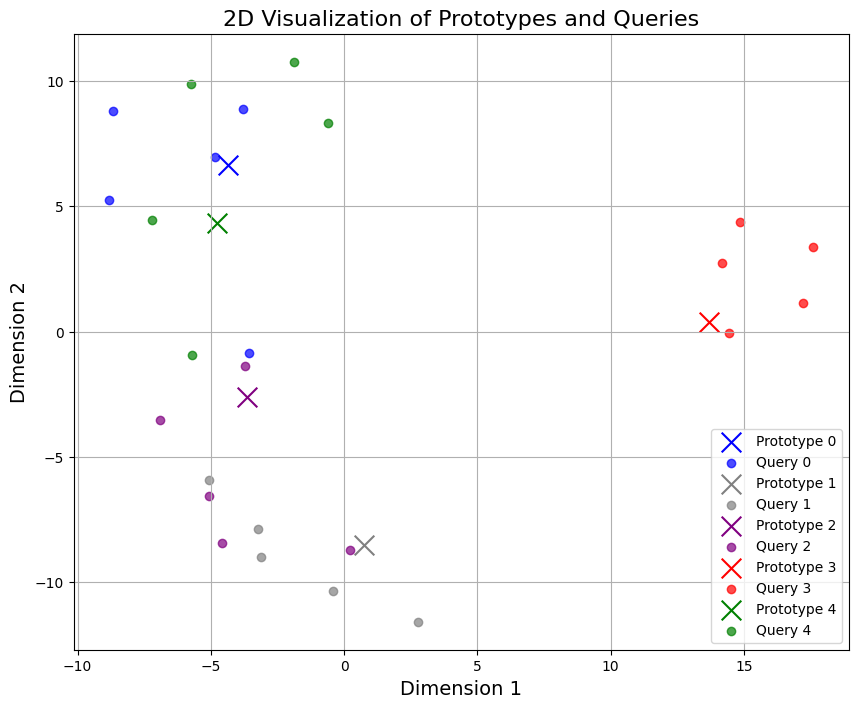

 80%|████████  | 16/20 [00:02<00:00,  5.08it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
0
2
3
4
5


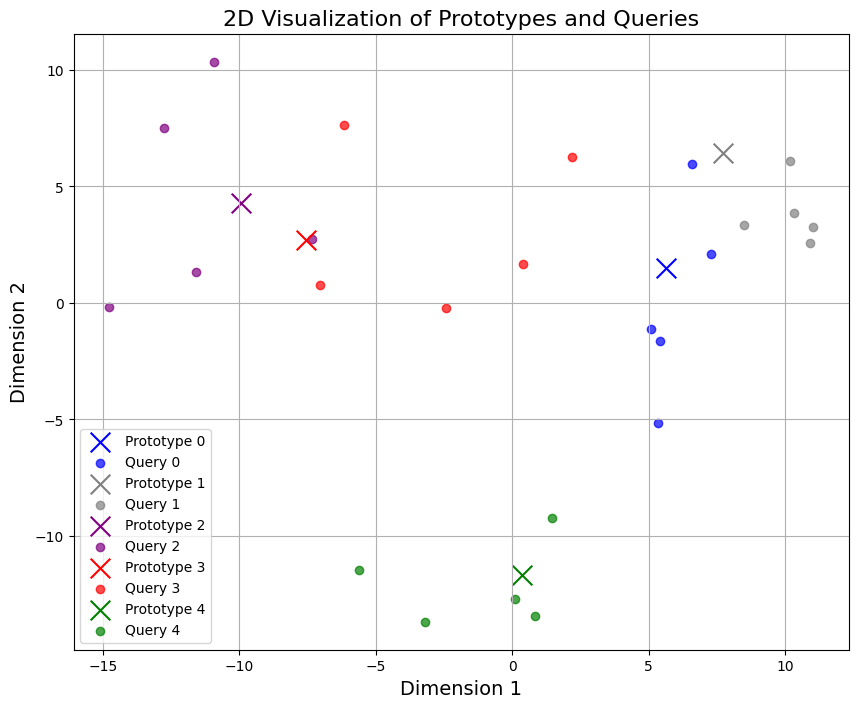

 85%|████████▌ | 17/20 [00:03<00:00,  5.16it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
2
4
5
7
8


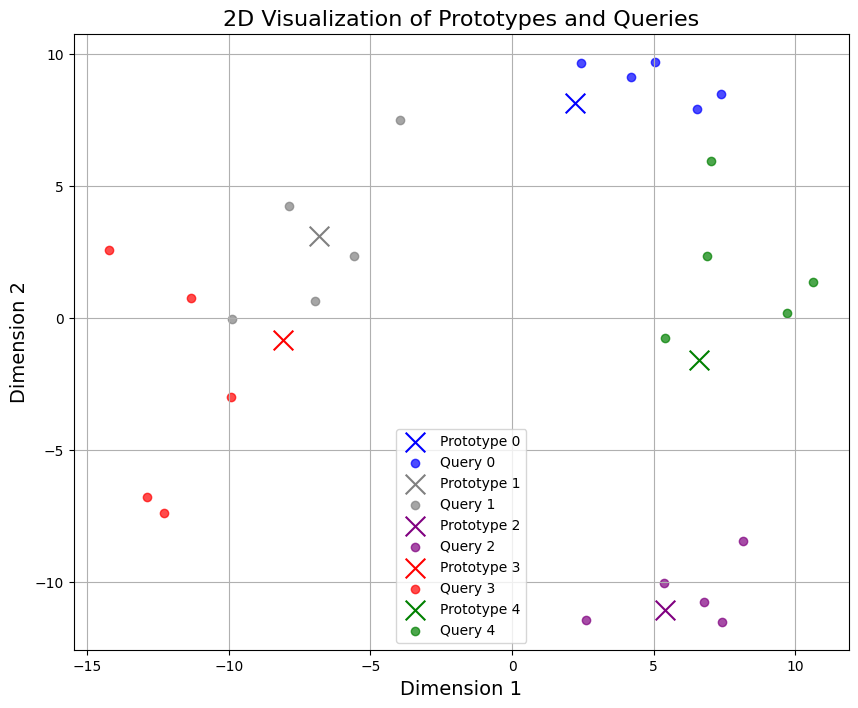

 90%|█████████ | 18/20 [00:03<00:00,  5.38it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
0
2
3
5
7


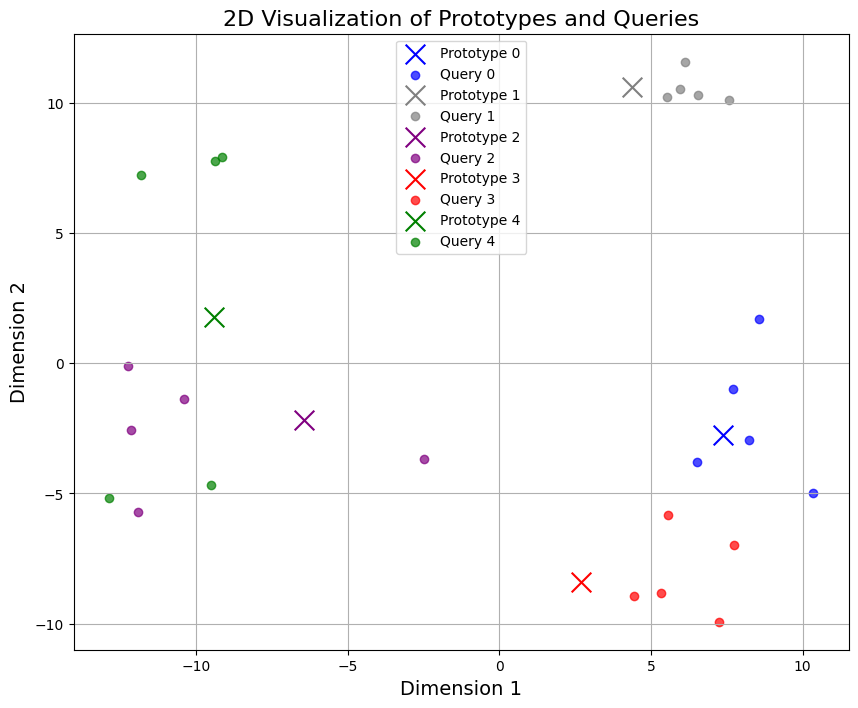

 95%|█████████▌| 19/20 [00:03<00:00,  4.91it/s]

{'vacuum_cleaner': 0, 'sneezing': 1, 'thunderstorm': 2, 'crow': 3, 'glass_breaking': 4, 'church_bells': 5, 'cow': 6, 'dog': 7, 'airplane': 8, 'engine': 9}
3
4
6
7
9


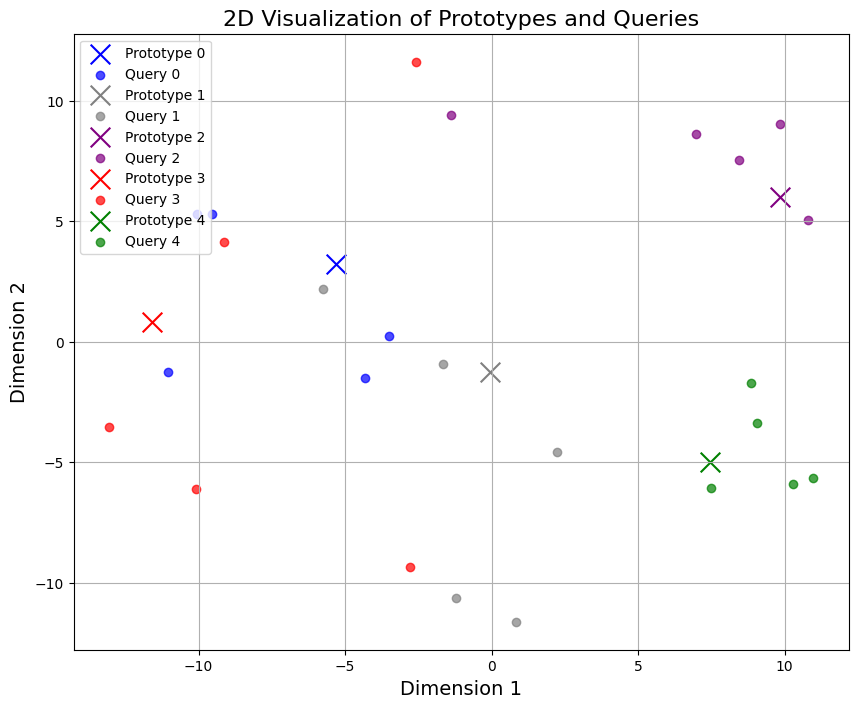

100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datasets.batch_creation import sample_episode
state_dict = torch.load("/home/csgouros/audio-few-shot-learning/experiments/nb_runs_ESC/model.pt")
few_shot_model.load_state_dict(state_dict)
def visualize(trained_model, test_dataset, k_support, n_classes, k_query, num_test_tasks, device):
    # Choose the dimensionality reduction technique
    decomp = PCA(n_components=2)
    trained_model.eval()
    with torch.no_grad():
        for task in tqdm(range(num_test_tasks)):
            # Sample a task (support and query sets)
            support_list, support_labels, query_list, query_labels, _ = sample_episode(
                dataset=test_dataset, k_support=k_support, k_query=k_query, 
                is_test=True, device=device, feat_extractor=feat_extractor, n_classes=n_classes)

            support_list = [tensor.to(device) for tensor in support_list]
            query_list = [tensor.to(device) for tensor in query_list]
            
            # Process the support set
            trained_model.process_support_set(support_list, support_labels)
            query_features = trained_model(query_list).to('cpu')
            prototypes = trained_model.prototypes.to('cpu')

            # Combine all query features and prototypes into a single batch
            all_features = torch.cat([query_features, prototypes], dim=0)  # Combine query features and prototypes
            all_features = all_features.numpy()  # Convert to numpy for dimensionality reduction

            # Apply dimensionality reduction (PCA or t-SNE) on the combined features
            reduced_features = decomp.fit_transform(all_features)

            # Separate the reduced features back into queries and prototypes
            decomp_query_features = reduced_features[:len(query_features)]
            decomp_prototypes = reduced_features[len(query_features):]

            # Plotting
            plt.figure(figsize=(10, 8))
            colors = ["blue", "grey", "purple", "red", "green"]
            
            for i in range(n_classes):
                # Plot prototypes
                plt.scatter(
                    decomp_prototypes[i, 0], 
                    decomp_prototypes[i, 1], 
                    color=colors[i % len(colors)], 
                    label=f'Prototype {i}', 
                    marker='x', 
                    s=200  # Larger size for prototypes
                )
                
                # Plot query features corresponding to the prototype
                start_idx = i * k_query
                end_idx = start_idx + k_query
                plt.scatter(
                    decomp_query_features[start_idx:end_idx, 0], 
                    decomp_query_features[start_idx:end_idx, 1], 
                    color=colors[i % len(colors)], 
                    label=f'Query {i}', 
                    alpha=0.7  # Slight transparency for queries
                )
            
            # Add plot details
            plt.title("2D Visualization of Prototypes and Queries", fontsize=16)
            plt.xlabel("Dimension 1", fontsize=14)
            plt.ylabel("Dimension 2", fontsize=14)
            plt.legend(loc='best', fontsize=10)
            plt.grid(True)
            plt.show()
visualize(trained_model = few_shot_model,test_dataset = test_set,  k_support = 5, n_classes = 5,k_query = 5, num_test_tasks = 20, device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

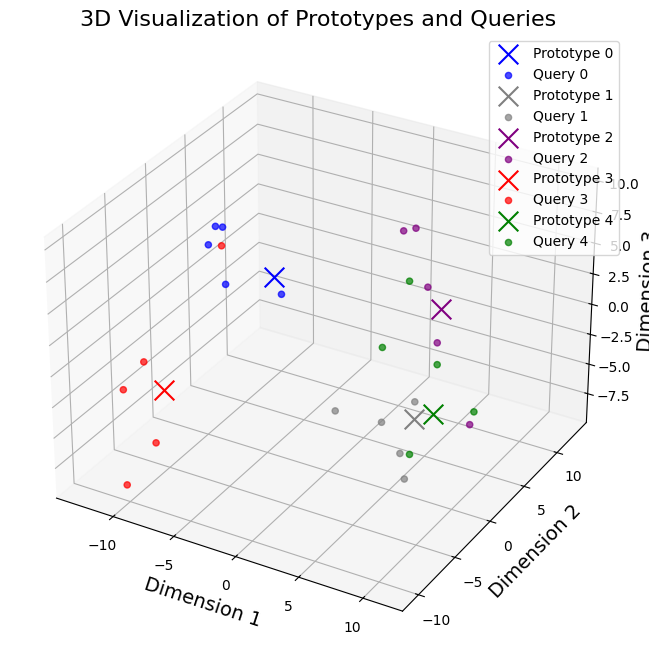

  5%|▌         | 1/20 [00:00<00:04,  4.40it/s]

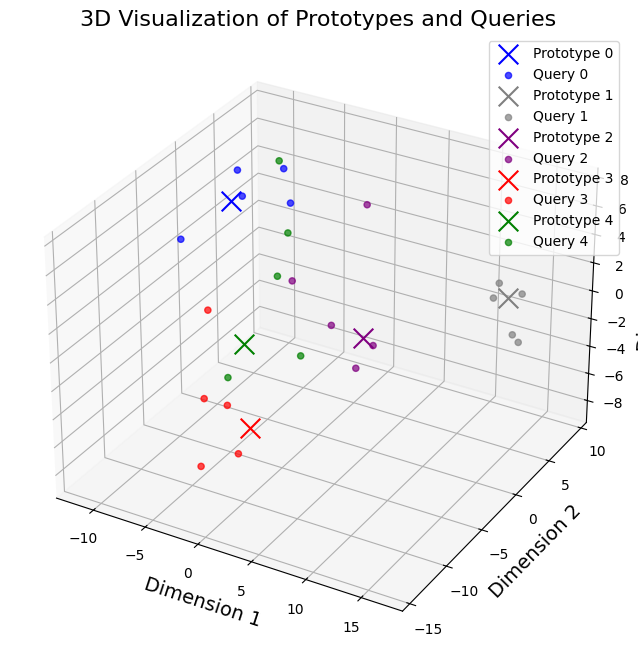

 10%|█         | 2/20 [00:00<00:03,  5.46it/s]

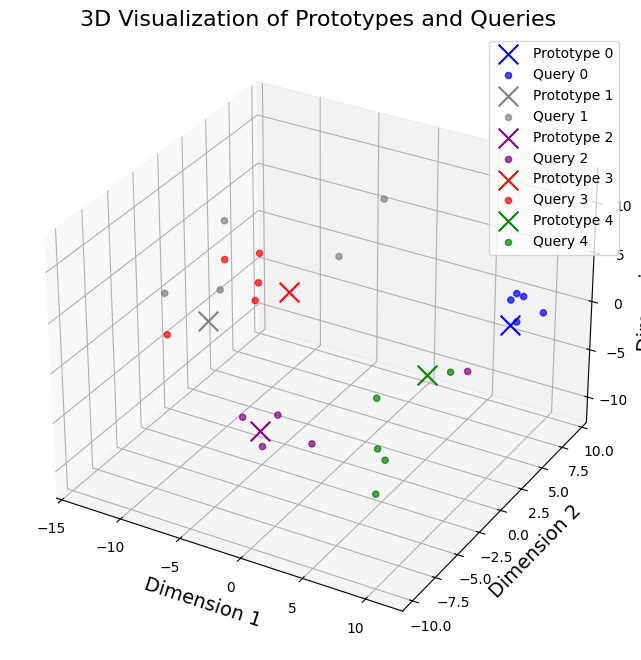

 15%|█▌        | 3/20 [00:00<00:02,  6.22it/s]

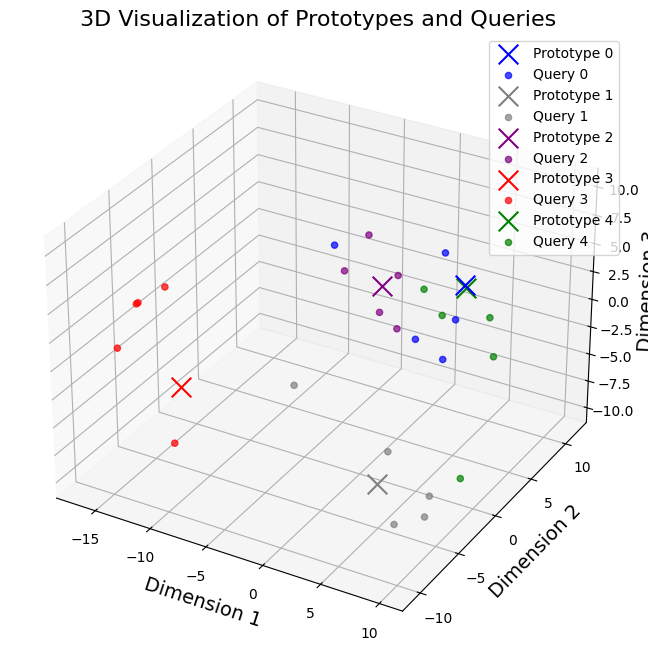

 20%|██        | 4/20 [00:00<00:03,  5.33it/s]

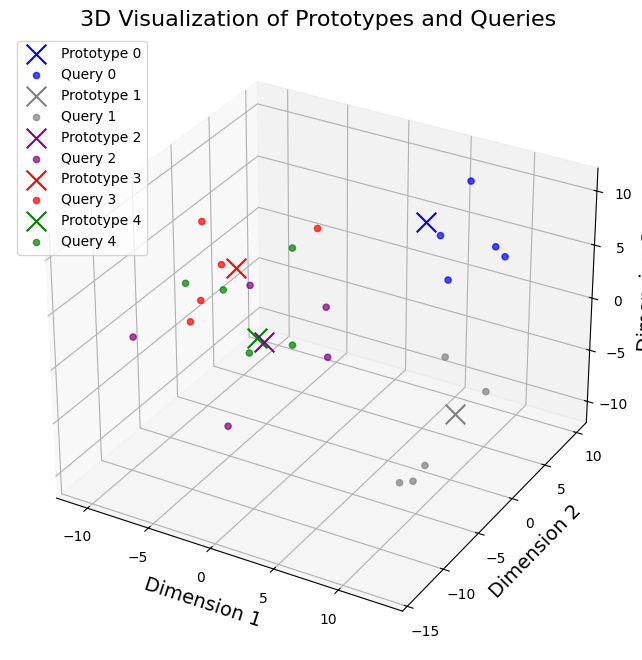

 25%|██▌       | 5/20 [00:00<00:02,  5.23it/s]

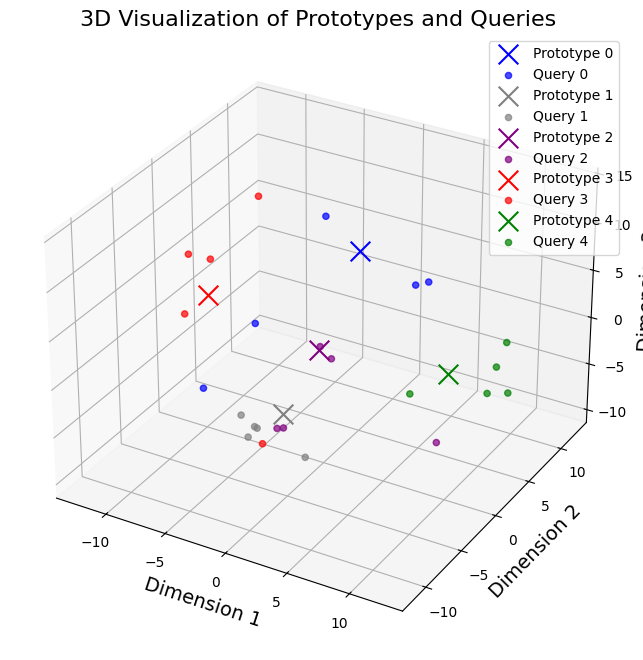

 30%|███       | 6/20 [00:01<00:02,  5.49it/s]

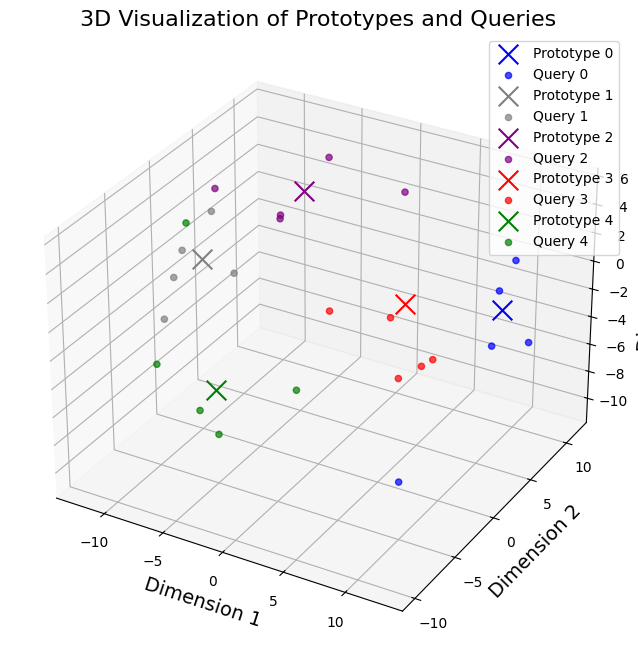

 35%|███▌      | 7/20 [00:01<00:02,  5.91it/s]

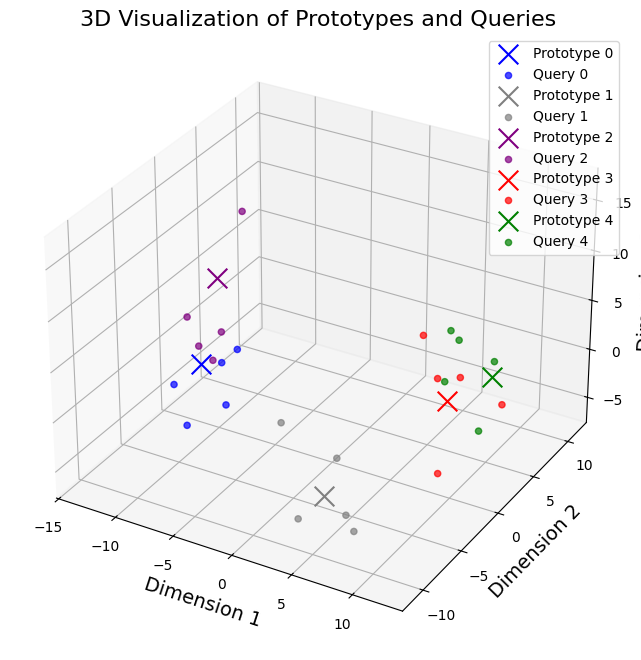

 40%|████      | 8/20 [00:01<00:01,  6.03it/s]

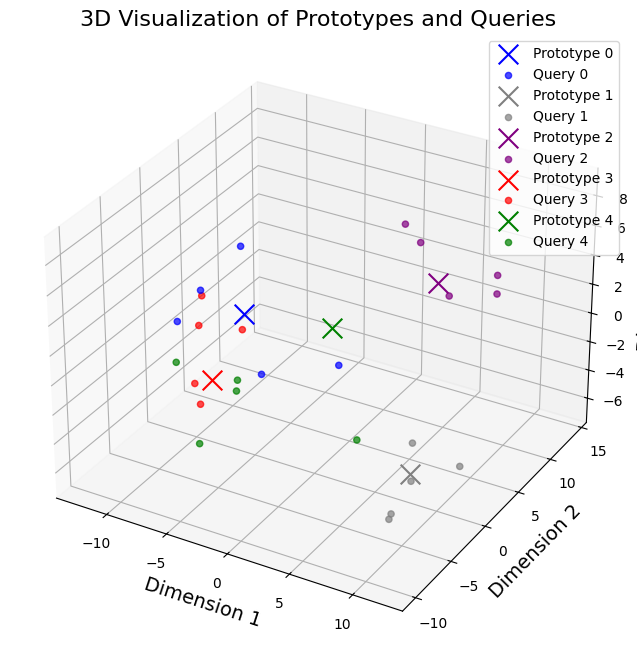

 45%|████▌     | 9/20 [00:01<00:01,  5.88it/s]

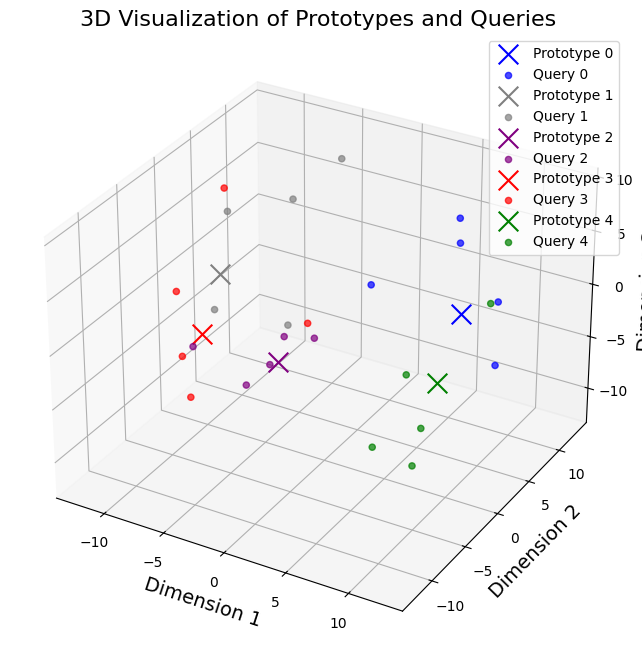

 50%|█████     | 10/20 [00:01<00:01,  5.52it/s]

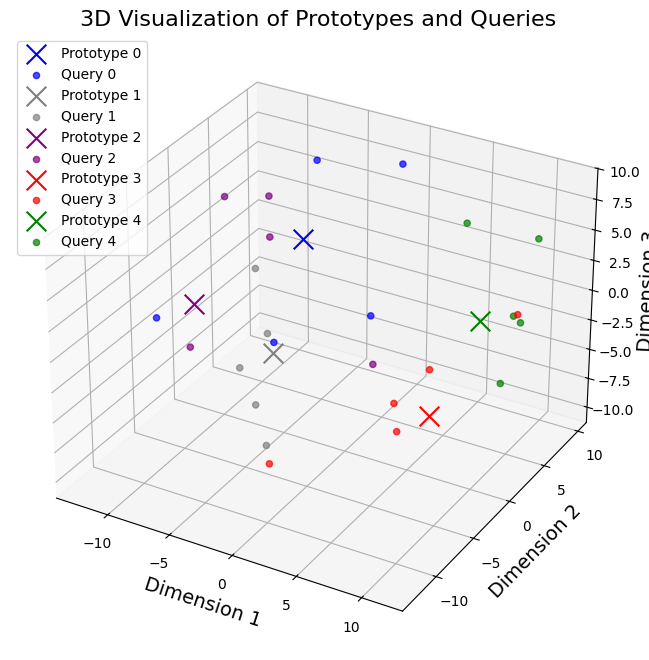

 55%|█████▌    | 11/20 [00:01<00:01,  5.66it/s]

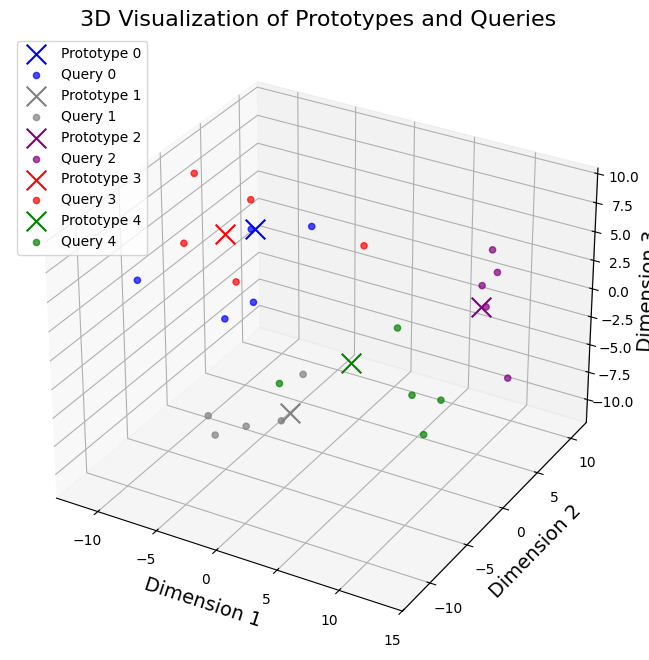

 60%|██████    | 12/20 [00:02<00:01,  5.80it/s]

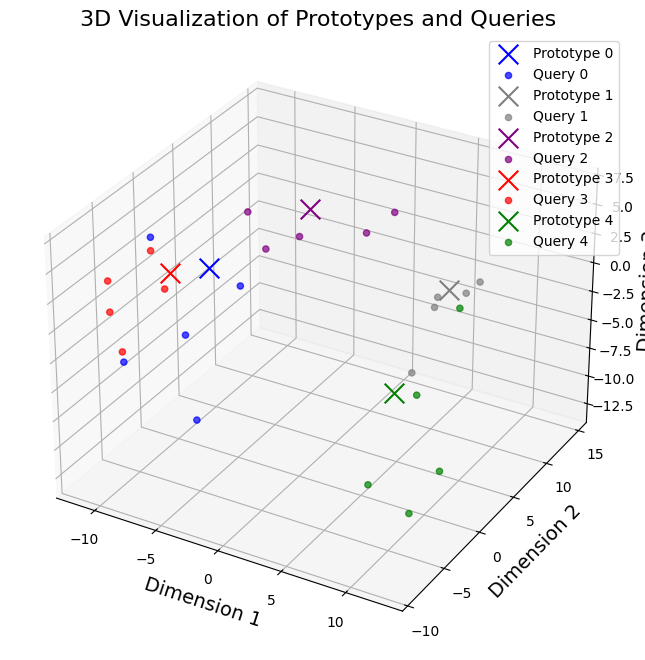

 65%|██████▌   | 13/20 [00:02<00:01,  5.99it/s]

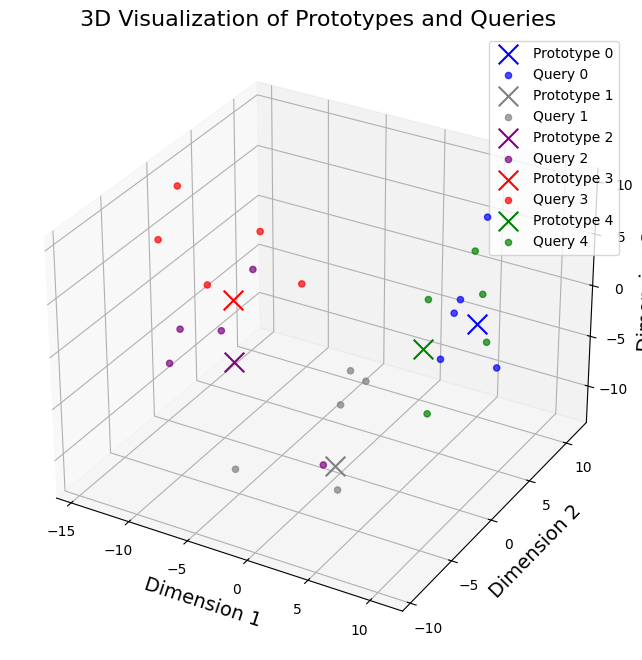

 70%|███████   | 14/20 [00:02<00:01,  4.78it/s]

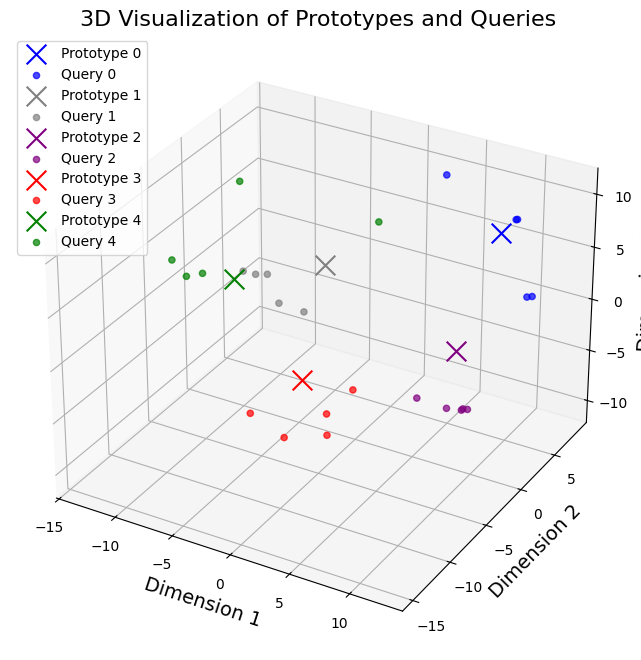

 75%|███████▌  | 15/20 [00:02<00:00,  5.20it/s]

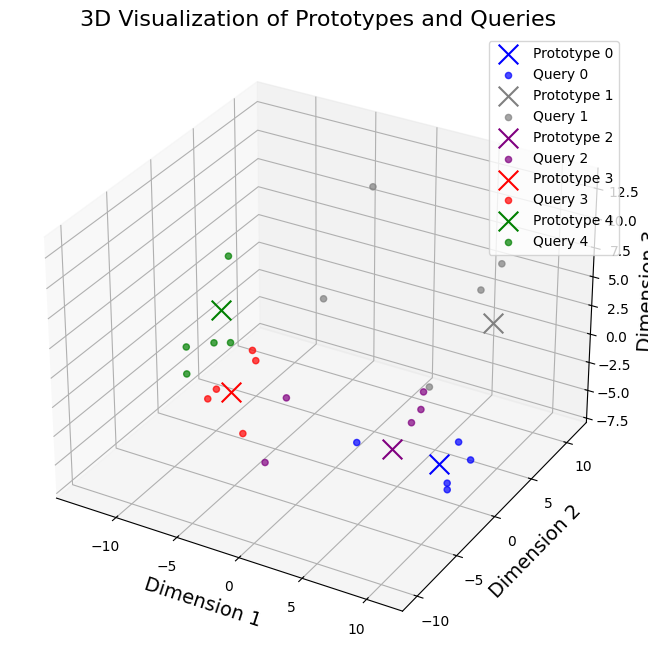

 80%|████████  | 16/20 [00:02<00:00,  5.47it/s]

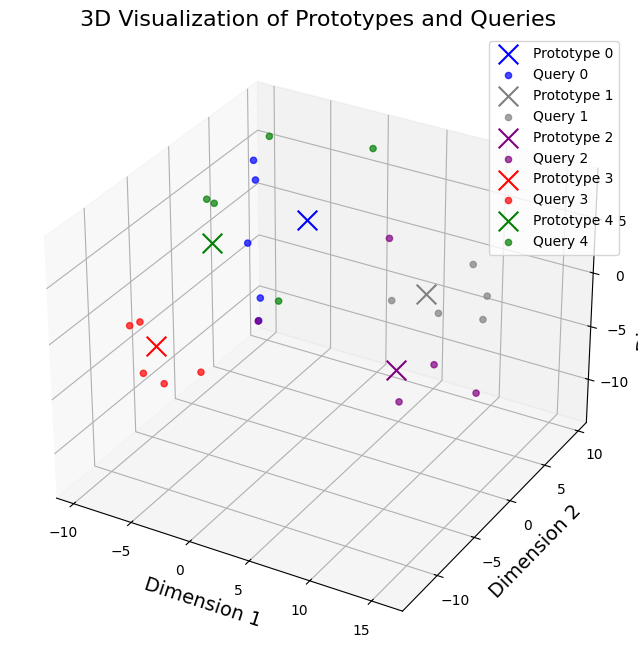

 85%|████████▌ | 17/20 [00:03<00:00,  5.64it/s]

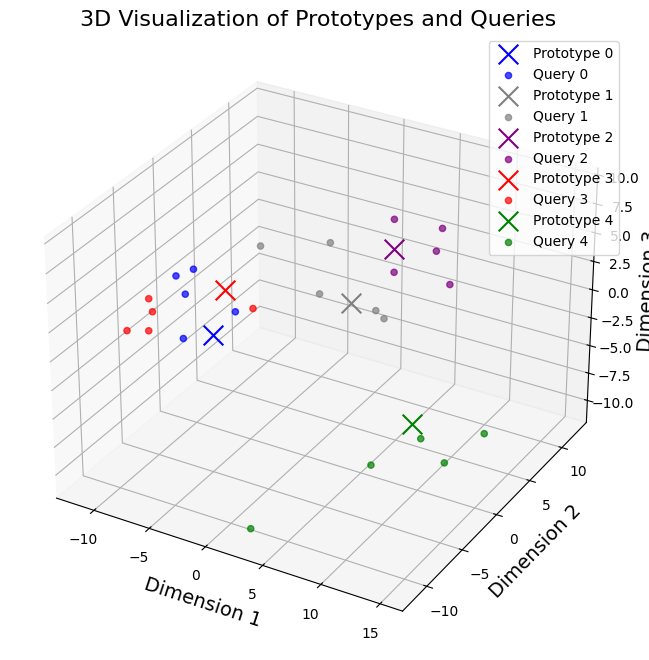

 90%|█████████ | 18/20 [00:03<00:00,  5.78it/s]

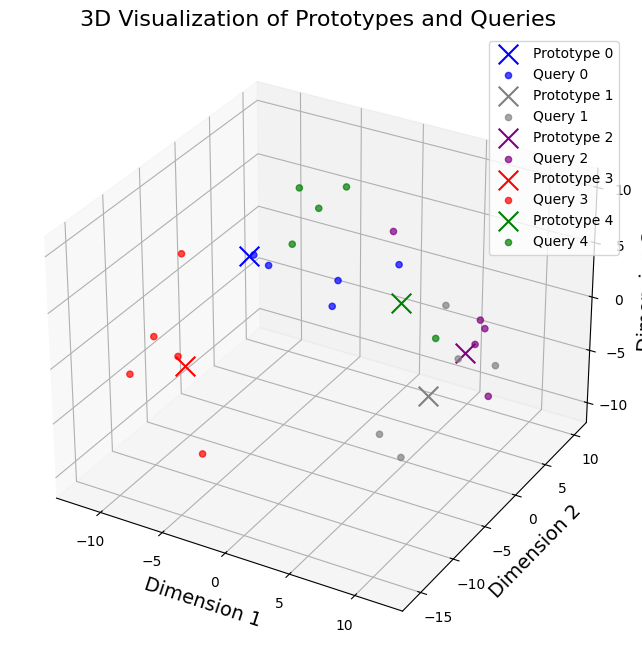

 95%|█████████▌| 19/20 [00:03<00:00,  6.19it/s]

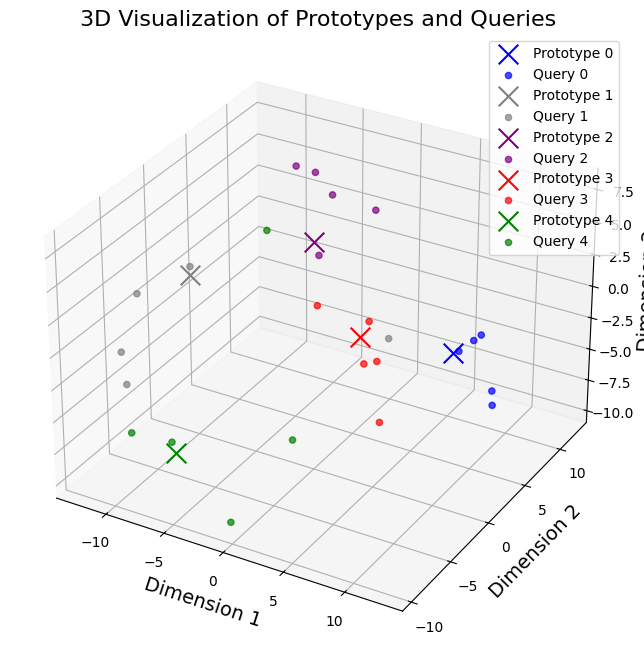

100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datasets.batch_creation import sample_episode
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def visualize(trained_model, test_dataset, k_support, n_classes, k_query, num_test_tasks, device):
    # Choose the dimensionality reduction technique
    decomp = PCA(n_components=3)
    trained_model.eval()
    with torch.no_grad():
        for task in tqdm(range(num_test_tasks)):
            # Sample a task (support and query sets)
            support_list, support_labels, query_list, query_labels, _ = sample_episode(
                dataset=test_dataset, k_support=k_support, k_query=k_query, 
                is_test=True, device=device, feat_extractor=feat_extractor, n_classes=n_classes)

            support_list = [tensor.to(device) for tensor in support_list]
            query_list = [tensor.to(device) for tensor in query_list]
            
            # Process the support set
            trained_model.process_support_set(support_list, support_labels)
            query_features = trained_model(query_list).to('cpu')
            prototypes = trained_model.prototypes.to('cpu')

            # Combine all query features and prototypes into a single batch
            all_features = torch.cat([query_features, prototypes], dim=0)  # Combine query features and prototypes
            all_features = all_features.numpy()  # Convert to numpy for dimensionality reduction

            # Apply dimensionality reduction (PCA or t-SNE) on the combined features
            reduced_features = decomp.fit_transform(all_features)

            # Separate the reduced features back into queries and prototypes
            decomp_query_features = reduced_features[:len(query_features)]
            decomp_prototypes = reduced_features[len(query_features):]

            # Plotting
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')  # 3D plot
            
            colors = ["blue", "grey", "purple", "red", "green"]
            
            for i in range(n_classes):
                # Plot prototypes
                ax.scatter(
                    decomp_prototypes[i, 0], 
                    decomp_prototypes[i, 1], 
                    decomp_prototypes[i, 2], 
                    color=colors[i % len(colors)], 
                    label=f'Prototype {i}', 
                    marker='x', 
                    s=200  # Larger size for prototypes
                )
                
                # Plot query features corresponding to the prototype
                start_idx = i * k_query
                end_idx = start_idx + k_query
                ax.scatter(
                    decomp_query_features[start_idx:end_idx, 0], 
                    decomp_query_features[start_idx:end_idx, 1], 
                    decomp_query_features[start_idx:end_idx, 2], 
                    color=colors[i % len(colors)], 
                    label=f'Query {i}', 
                    alpha=0.7  # Slight transparency for queries
                )
            
            # Add plot details
            ax.set_title("3D Visualization of Prototypes and Queries", fontsize=16)
            ax.set_xlabel("Dimension 1", fontsize=14)
            ax.set_ylabel("Dimension 2", fontsize=14)
            ax.set_zlabel("Dimension 3", fontsize=14)
            ax.legend(loc='best', fontsize=10)
            plt.show()

# Example usage:
visualize(trained_model = few_shot_model, test_dataset=test_set, k_support=5, n_classes=5, k_query=5, num_test_tasks=20, device=device)
